# exploration 14 영화 추천  
● 추천 시스템을 활용해 영화 추천하기  
● 시작하기에 앞서 ratings 데이터의 'ratings' 컬럼은 'count'로 바꾸지 않고 그대로 사용하겠습니다.  
평점 데이터로 영화 추천 => rating을 높게 준 영화와 같은 장르의 다른 영화 추천  
최신 영화 추천 아니면 고전 영화 추천 => 데이터가 최신 영화 평점이 많아 imbalance data로 평가됨 

# 데이터 불러오기

In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [395]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 메타 데이터 불러오기

In [396]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

# 데이터 전처리 및 EDA

In [397]:
ratings['ratings'].describe() 

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

● counts의 50% 이상이 4.0이므로 유저들이 대체로 영화에 대해 후한 점수를 주었음을 알 수 있음  

● ratings의 timestamp 열은 유닉스시간으로 표기되어 있음, 이를 알아보기 쉽게 datetime으로 변환  

In [398]:
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.sort_values(by='date')

,user_id,movie_id,ratings,timestamp,date
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08


In [399]:
del(ratings['timestamp'])#timestamp 삭제 
ratings.head()

,user_id,movie_id,ratings,date
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [400]:
print("평점 최초로 남긴 날: {}".format(ratings['date'].min()))
print("평점 마지막으로 남긴 날: {}".format(ratings['date'].max()))

평점 최초로 남긴 날: 2000-04-25 23:05:32
평점 마지막으로 남긴 날: 2003-02-28 17:49:50


● 해당 데이터가 2000-04-25부터 2003-02-28까지 기록된 것임을 알 수 있음  
● 내가 좋아하는 영화 추가할 때 2003년 2월 28일 이전의 영화를 추천 해야함 

In [401]:
#루브릭
ratings['movie_id'].nunique() #ratings에 있는 유니크한 영화 개수  

3706

In [402]:
#루브릭
ratings['user_id'].nunique() #rating에 있는 유니크한 사용자 수

6040

In [403]:
# 영화별 평균 평점을 탐색해보자
movie_grouped_rating_info = ratings.groupby("movie_id")['ratings'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [404]:
movie_grouped_rating_info.describe()

,rated_count,rating_mean
count,3706.000000,3706.000000
mean,269.889099,3.238892
std,384.047838,0.672925
min,1.000000,1.000000
25%,33.000000,2.822705
50%,123.500000,3.331546
75%,350.000000,3.740741
max,3428.000000,5.000000


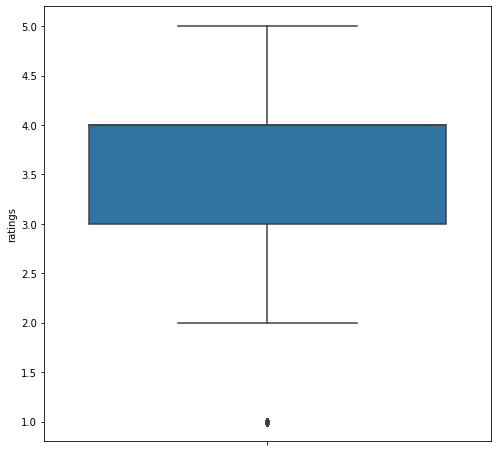

In [405]:
sns.boxplot(y = "ratings", data = ratings)
plt.show()

● 영화 평점의 대부분이 3.0~4.0에 몰려 있는 imbalance data 입니다.  
● 대부분의 유저가 영화에 후한 점수를 줬습니다.  
● 평점이 3.0 이상인 영화를 추천하기 위해 그 이하의 데이터는 삭제합니다.  

In [406]:
ratings = ratings[ratings['ratings']>=3] # 3점 이상만 남깁니다.
filtered_data_size = len(ratings)
print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


● 전체 데이터 중 83.63%가 남았습니다.  
● date는 평점을 남긴 날인데 일단 삭제 하겠습니다.(아마 분석하면 '어떤 요일 혹은 어떤 시간대에는 어떤 장르의 영화를 많이 봤을 것이다'라는 정보가 나올 것으로 예상하지만 시간 관계상 여기까지 하겠습니다.)   

In [407]:
del(ratings['date'])
ratings.head()

,user_id,movie_id,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


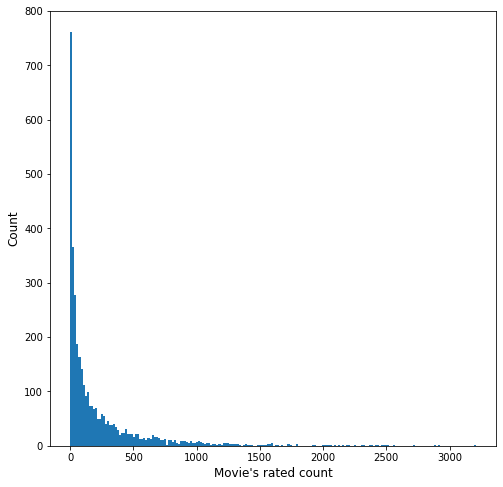

In [408]:
# 각 영화가 평가 받은 횟수를 탐색
movie_rate_count = ratings.groupby('movie_id')['ratings'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [409]:
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100])) #100번 미만으로 평점 받은 경우

total number of movie rated below 100 : 1911


● 100번 미만으로 평점 받은 영화의 개수는 1911개 입니다.  

### movies data 분석

In [410]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [411]:
movies['year'] = movies['title'].apply(lambda x:x[-5:-1]) #영화에서 년도만 따로 빼서 컬럼을 만들어줍니다.

In [412]:
movies['year'].value_counts().head(10) ## 연도별 영화 개수가 많은 top10 연도를 출력한다.

1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

● 상위 10개는 1990년대 영화가 대부분임을 알 수 있습니다. 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


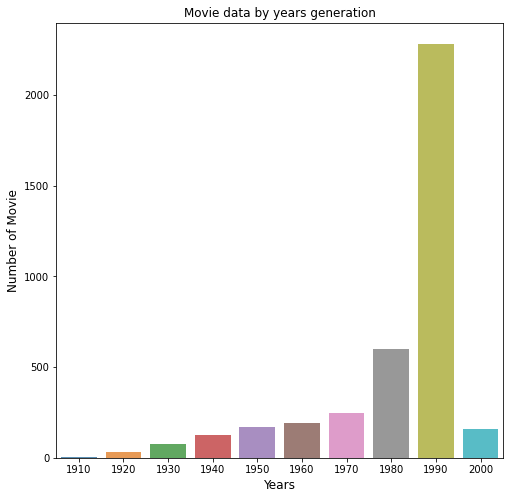

In [413]:
# 영화의 연대별 영화 수를 출력한다.(10년 간격으로 구간 설정)
movies['year_term'] = movies['title'].apply(lambda x: x[-5:-2]+"0")
movie_year_term = movies['year_term'].value_counts().sort_index()
           
           
sns.barplot(movie_year_term.index, movie_year_term.values, alpha = 0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movie', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

● 년도별 영화 개수 차이가 커 imbalance data 임을 알 수 있습니다.  
● 이러한 imbalance data는 1990년대 영화를 위주로 추천하는데 영향을 줄 것으로 예상됩니다.  

In [414]:
# 총 영화의 개수를 출력한다.
print("total number of movie in data:",len(movies['movie_id'].unique()))

total number of movie in data: 3883


In [415]:
# 가장 많이 등장한 장르의 속성을 추출한다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movies.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리한다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장한다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


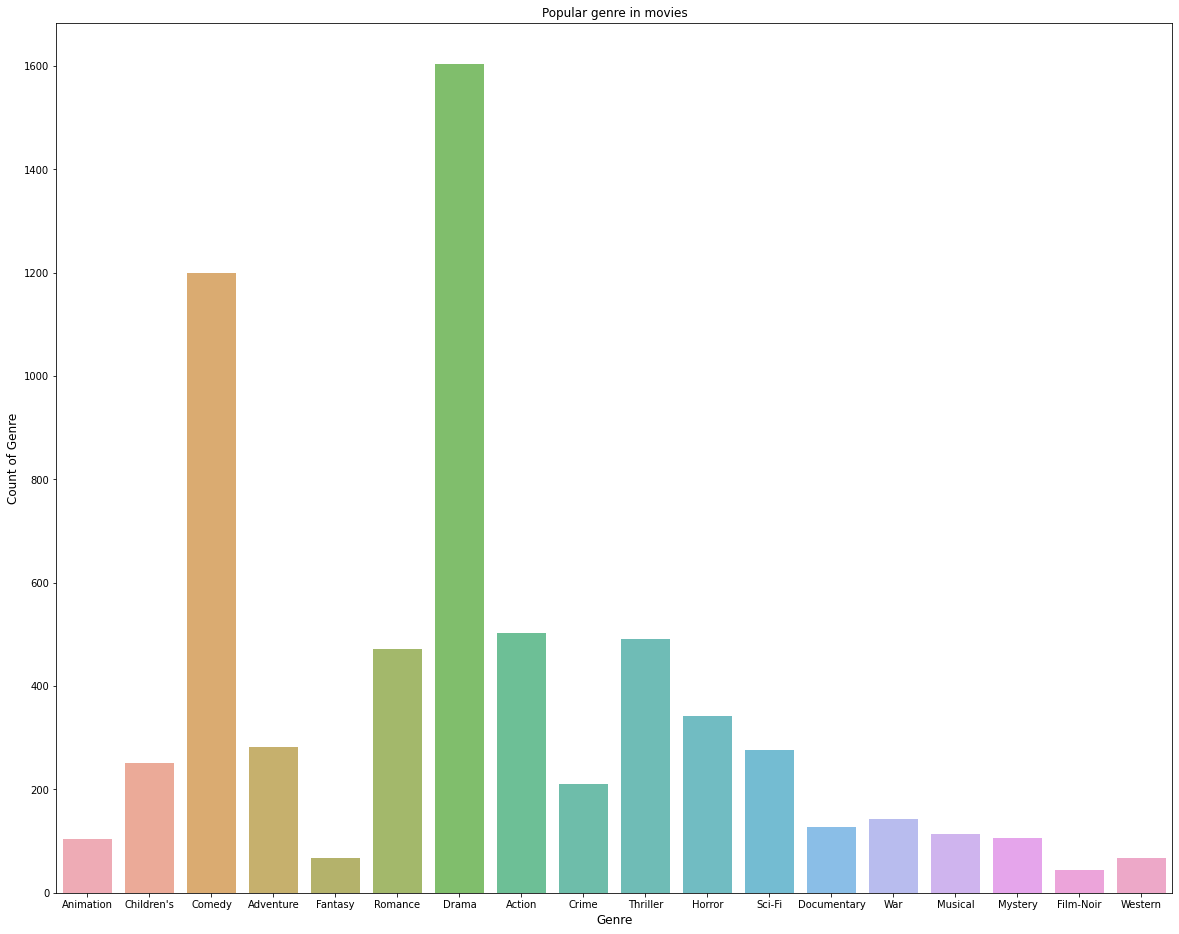

In [416]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력한다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

● 영화 평점은 Drama, Comedy, Action, Thriller 순으로 많았습니다.  
● 이는 western이나 documentary 같이 데이터가 적은 경우는 추천이 잘 안될 가능성이 있습니다.  
● 혹은 western 장르를 추천하돼 western이 아닌 fantasy 같은 다른 장르의 영화가 추천될 가능성도 있습니다.  

In [417]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력한다.
merged_data = movie_grouped_rating_info.merge(movies, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title','genre']].nlargest(10, 'rating_mean')

,rating_mean,title,genre
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
309,4.554558,"Shawshank Redemption, The (1994)",Drama
802,4.524966,"Godfather, The (1972)",Action|Crime|Drama
708,4.520548,"Close Shave, A (1995)",Animation|Comedy|Thriller
49,4.517106,"Usual Suspects, The (1995)",Crime|Thriller
513,4.510417,Schindler's List (1993),Drama|War
1066,4.507937,"Wrong Trousers, The (1993)",Animation|Comedy
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1108,4.477725,Raiders of the Lost Ark (1981),Action|Adventure
843,4.476190,Rear Window (1954),Mystery|Thriller


### movies와 ratings 두 데이터를 합치겠습니다.

In [418]:
data = pd.merge(movies, ratings)
data.head()

,movie_id,title,genre,year,year_term,user_id,ratings
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,10,5


In [419]:
del(data['year_term'])

In [420]:
#가장 인기있는 영화 30개(인기순)
movies_count = data.groupby('title')['user_id'].count()
movies_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

● 평점을 가장 많이 준 영화는 아메리칸 뷰티였고 그다음은 스타워즈 시리즈 입니다.  
● 스타워즈가 상위권인 것으로 보아 해당 데이터는 미국에서 수집되었음이 예상됩니다.  
● 위에서 평점을 100번 이상 받은 영화 리스트랑 겹치는 영화도 있고 없는 영화도 있습니다.  

In [421]:
f = ['count','mean']
df_cust_summary = data.groupby('user_id')['ratings'].agg(f) #유저별 평점 매긴 개수와 평균 
df_cust_summary.index = df_cust_summary.index.map(int) #정수형 형변환 
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0) #70%까지
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index #30% 미만으로 평점을 매긴 유저들

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 149.0


● 리뷰를 남긴 유저 중 리뷰를 가장 적게 남긴 149명 추출  
● 해당 고객은 충성 고객이 아닐 가능성이 크거나 위 리스트에 있는 영화를 그닥 좋아하지 않았거나 아니면 영화가 좋았지만 평점 남기는 걸 귀찮아하는 성격일 수 있음   

In [422]:
print('Original Shape: {}'.format(data.shape)) #원래 데이터 크기
data = data[~data['user_id'].isin(drop_cust_list)] #평점을 적게 남긴 유저 삭제
print('After Trim Shape: {}'.format(data.shape)) #삭제 후 데이터 크기 

Original Shape: (836478, 6)
After Trim Shape: (577224, 6)


● 평점을 적게 남긴 유저를 제거하니 836478 -> 577224로 줄어들었습니다.  

In [423]:
data['user_id'].max() #data에 있는 user_id의 최댓값

6040

### 제가 좋아하는 영화 5개를 추가하겠습니다.  
● 우선 입력이 편리하도록 영화 제목을 소문자로 바꾸겠습니다.

In [424]:
data['title'] = data['title'].str.lower() 

● 노드에 있는 데이터 추가 방식과 다르게 데이터를 추가하겠습니다.  

In [425]:
#내가 좋아하는 영화의 장르와 movie_id 찾기 
#for idx, i in enumerate(data['title']):
#    if 'ghostbusters (1984)' == i: 
#        #print(data.iloc[idx, 2]) ##Comedy|Sci-Fi
        #print(data.iloc[idx, 0]) #1270.0
#    elif 'as good as it gets (1997)' == i: 
        #print(data.iloc[idx, 2]) #Drama
        #print(data.iloc[idx, 0]) #1682.0
#    elif 'fight club (1999)' == i:
        #print(data.iloc[idx, 2]) #Comedy|Drama
        #print(data.iloc[idx, 0]) #1784.0
#    elif 'back to the future (1985)' == i:
        #print(data.iloc[idx, 2]) #Comedy|Horror
        #print(data.iloc[idx, 0]) #2716.0
#    elif 'truman show, the (1998)' == i:
        #print(data.iloc[idx, 2]) #Drama
        #print(data.iloc[idx, 0]) #2959.0

In [426]:
my_movies = ['ghostbusters (1984)' , 'as good as it gets (1997)' ,'fight club (1999)' ,
               'back to the future (1985)' ,'truman show, the (1998)'] #좋아하는 영화 목록 
my_movie_id = [1270.0, 1682.0, 1784.0, 2716.0, 2959.0] #movie_id
my_genre = ['Comedy|Sci-Fi', 'Drama', 'Comedy|Drama', 'Comedy|Horror', 'Drama'] #genre
my_year = [1984, 1997, 1999, 1985, 1998] #영화 개봉일 
my_id = [6041, 6041, 6041, 6041, 6041] #나의 id 
my_ratings = [5, 5, 4, 5, 5] #내가 준 평점 
my_data = pd.DataFrame({'movie_id':my_movie_id, 'title':my_movies, 'genre':my_genre, 'year':my_year, 'user_id':my_id, 'ratings':my_ratings}) #데이터프레임 생성 
my_data.head()

,movie_id,title,genre,year,user_id,ratings
0,1270.0,ghostbusters (1984),Comedy|Sci-Fi,1984,6041,5
1,1682.0,as good as it gets (1997),Drama,1997,6041,5
2,1784.0,fight club (1999),Comedy|Drama,1999,6041,4
3,2716.0,back to the future (1985),Comedy|Horror,1985,6041,5
4,2959.0,"truman show, the (1998)",Drama,1998,6041,5


### 1.모델에 사용할 데이터 생성(평점으로 영화 추천)   
● 평점을 적게 준 유저를 삭제한 데이터를 사용하겠습니다. 이는 삭제한 데이터를 이상치로 판단했기 때문입니다.  

In [427]:
new_data = pd.concat([data, my_data]) #기존 데이터와 나의 데이터 합치기 
new_data = new_data[['user_id', 'title', 'ratings']] #사용할 열만 선별 
new_data.sort_index() #인덱스 새로 정렬 

,user_id,title,ratings
0,6041,ghostbusters (1984),5
1,6041,as good as it gets (1997),5
2,6041,fight club (1999),4
3,6041,back to the future (1985),5
4,10,toy story (1995),5
...,...,...,...
836471,5475,"contender, the (2000)",5
836473,5682,"contender, the (2000)",3
836474,5812,"contender, the (2000)",4
836475,5831,"contender, the (2000)",3


In [428]:
# 고유한 유저, 타이틀을 찾아내는 코드
user_unique = new_data['user_id'].unique()
title_unique = new_data['title'].unique()

# 유저, 타이틀 indexing 하는 코드 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [429]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = new_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(new_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    new_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = new_data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(new_data):
    print('title column indexing OK!!')
    new_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

new_data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,ratings
4,0,0,5
5,1,0,4
6,2,0,5
8,3,0,4
9,4,0,3
...,...,...,...
0,1818,2437,5
1,1818,1569,5
2,1818,2671,4
3,1818,1141,5


### csr matrix 직접 만들기

In [430]:
from scipy.sparse import csr_matrix

num_user = new_data['user_id'].nunique()
num_movie = new_data['title'].nunique()

csr_data = csr_matrix((new_data.ratings, (new_data.user_id, new_data.title)), shape=(num_user, num_movie)) #csr matrix 생성 
csr_data

<1819x3583 sparse matrix of type '<class 'numpy.int64'>'
	with 577229 stored elements in Compressed Sparse Row format>

### AlternatingLeastSquares 모델 구성

In [431]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [432]:
# Implicit AlternatingLeastSquares 모델의 선언, iteration은 나중에 바꿔주겠습니다.
als_model = AlternatingLeastSquares(factors=100, regularization=0.001, use_gpu=False, iterations=1000, dtype=np.float32)

In [433]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3583x1819 sparse matrix of type '<class 'numpy.int64'>'
	with 577229 stored elements in Compressed Sparse Column format>

In [434]:
als_model.fit(csr_data_transpose) #모델 학습 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [435]:
user_to_idx[6041] #변경된 나의 인덱스 확인  

1818

In [436]:
min, back_to_the_future = user_to_idx[6041], title_to_idx['back to the future (1985)']
min_vector, back_to_the_future_vector = als_model.user_factors[1818], als_model.item_factors[back_to_the_future]

In [437]:
min_vector

array([ 0.17302683,  0.41958442,  0.04107038, -0.30502304,  0.40468496,
        0.16591582,  0.11923205, -0.14640206, -0.01901364, -0.4032445 ,
        0.0997691 ,  0.09114903,  0.15491025,  0.14629456,  0.28555325,
        0.12760723,  0.27306372, -0.3751205 , -0.17301707, -0.40693477,
        0.3042762 ,  0.0559405 , -0.15241379, -0.5289718 , -0.19064009,
       -0.30732295, -0.38884604,  0.33387247,  0.09693135,  0.12776145,
        0.5440955 ,  0.19416767, -0.1493915 , -0.22254537,  0.3393562 ,
        0.30150282,  0.02550085, -0.27371547,  0.12817754,  0.42284554,
       -0.01285926,  0.2016598 , -0.4175822 ,  0.081478  , -0.3022858 ,
       -0.17817116,  0.16756774,  0.05345111,  0.03779902,  0.25735435,
        0.18146645, -0.15233067, -0.26745796, -0.0257952 ,  0.15427293,
        0.14742413,  0.02367663,  0.32150105,  0.2576605 ,  0.24714825,
        0.09540157,  0.14565958, -0.21746427, -0.01521039,  0.52339214,
        0.12475614,  0.20483324, -0.26014954,  0.09414436,  0.13

In [438]:
 back_to_the_future_vector

array([ 0.01280363,  0.01247119, -0.00734329, -0.01271886,  0.02137759,
       -0.00388471,  0.00618805, -0.00274443,  0.00824337, -0.04230862,
        0.0062171 ,  0.01030823,  0.02489292,  0.01399615, -0.00258424,
        0.0195755 ,  0.04582845, -0.02551896,  0.00817033, -0.00124716,
        0.01670256,  0.02024768,  0.00227389,  0.00308142, -0.01502013,
       -0.0131571 , -0.01491125,  0.00561123,  0.02353334,  0.02917439,
        0.04201834,  0.00693885,  0.00878954,  0.00599533,  0.02949103,
        0.00924818,  0.01897951, -0.00280632, -0.02233791,  0.06336085,
        0.02177244,  0.01933242, -0.00346275, -0.02241967, -0.01115207,
        0.00491574,  0.02549981, -0.00507057,  0.00666442,  0.01610834,
        0.00843785,  0.0104203 ,  0.01703425,  0.00546897,  0.01567867,
        0.02340543, -0.00359838,  0.01452939,  0.00052996,  0.00237643,
       -0.00828195,  0.02645593, -0.00729676,  0.00583957,  0.02033779,
        0.01099218,  0.01013503, -0.0080297 ,  0.00907268,  0.02

### 훈련된 모델이 예측한 나의 선호도 파악 

In [439]:
np.dot(min_vector, back_to_the_future_vector)

0.23104498

● iterations를 1000으로 늘려도 그닥 1에 가까워지지 않네요...  

In [440]:
toy = title_to_idx['toy story (1995)']
toy_vector = als_model.item_factors[toy]
np.dot(min_vector, toy_vector)

0.16777268

### 내가 좋아하는 영화와 비슷한 영화 추천 받기

In [441]:
idx_to_title = {v:k for k,v in title_to_idx.items()}

def get_similar_title(title_name: str):
    title_id = title_to_idx[title_name]
    similar_title = als_model.similar_items(title_id)
    similar_title = [idx_to_title[i[0]] for i in similar_title]
    return similar_title

In [442]:
get_similar_title('back to the future (1985)') 

['back to the future (1985)',
 'star wars: episode vi - return of the jedi (1983)',
 'star wars: episode v - the empire strikes back (1980)',
 'e.t. the extra-terrestrial (1982)',
 'star wars: episode iv - a new hope (1977)',
 'ghostbusters (1984)',
 'princess bride, the (1987)',
 'raiders of the lost ark (1981)',
 'men in black (1997)',
 'forrest gump (1994)']

● 제가 좋아하는 영화로 추가했던 ghostbusters가 추천되었네요

### 내가 좋아할 만한 영화들을 추천 받기

In [443]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
title_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
for i in title_recommended: 
    print("{} {:08.3f}".format(idx_to_title[i[0]], i[1]))

apollo 13 (1995) 0000.250
good will hunting (1997) 0000.210
forrest gump (1994) 0000.196
jerry maguire (1996) 0000.196
big (1988) 0000.194
star wars: episode v - the empire strikes back (1980) 0000.194
ferris bueller's day off (1986) 0000.193
groundhog day (1993) 0000.191
rain man (1988) 0000.191
american beauty (1999) 0000.191
beetlejuice (1988) 0000.188
airplane! (1980) 0000.188
star wars: episode vi - return of the jedi (1983) 0000.182
there's something about mary (1998) 0000.181
boogie nights (1997) 0000.179
e.t. the extra-terrestrial (1982) 0000.178
back to the future part ii (1989) 0000.178
men in black (1997) 0000.175
star wars: episode iv - a new hope (1977) 0000.174
edward scissorhands (1990) 0000.172


In [444]:
title = title_to_idx['speed (1994)']
explain = als_model.explain(user, csr_data, itemid=title)
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('truman show, the (1998)', 0.03783512778627886),
 ('ghostbusters (1984)', 0.02813243787999988),
 ('back to the future (1985)', 0.004708578118475386),
 ('fight club (1999)', -0.0004237421117895115),
 ('as good as it gets (1997)', -0.0031019512100531298)]

### Case2: 평점을 적게 매긴 유저의 데이터를 삭제하지 않고 그대로 사용하겠습니다.  

● 데이터 생성 

In [377]:
no_del_data = pd.merge(movies, ratings) 
no_del_data = pd.concat([no_del_data, my_data])
no_del_data = no_trim_data[['user_id', 'title', 'ratings']] #내가 사용할 열만 가져옴 
no_del_data.sort_index() #인덱스 정렬
no_del_data.head()

,user_id,title,ratings
0,1,toy story (1995),5
1,6,toy story (1995),4
2,8,toy story (1995),4
3,9,toy story (1995),5
4,10,toy story (1995),5


In [378]:
# 고유한 유저, 타이틀을 찾아내는 코드
user_unique2 = no_del_data['user_id'].unique()
title_unique2 = no_del_data['title'].unique()

# 유저, 타이틀 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx2 = {v:k for k,v in enumerate(user_unique2)}
title_to_idx2 = {v:k for k,v in enumerate(title_unique2)}

In [379]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = no_del_data['user_id'].map(user_to_idx2.get).dropna()
if len(temp_user_data) == len(no_del_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    no_del_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = no_del_data['title'].map(title_to_idx2.get).dropna()
if len(temp_title_data) == len(no_del_data):
    print('title column indexing OK!!')
    no_del_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

no_del_data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,ratings
0,0,0,5
1,1,0,4
2,2,0,4
3,3,0,5
4,4,0,5
...,...,...,...
0,6039,2462,5
1,6039,1584,5
2,6039,2697,4
3,6039,1152,5


In [387]:
num_user2 = no_del_data['user_id'].nunique()
num_movie2 = no_del_data['title'].nunique()

csr_data2 = csr_matrix((no_del_data.ratings, (no_del_data.user_id, no_del_data.title)), shape=(num_user2, num_movie2))
csr_data2

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [388]:
csr_data_transpose2 = csr_data2.T
csr_data_transpose2

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [389]:
als_model2 = AlternatingLeastSquares(factors=100, regularization=0.001, use_gpu=False, iterations=1000, dtype=np.float32)

In [390]:
als_model2.fit(csr_data_transpose2) #모델 학습 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [384]:
user_to_idx[6041]

1818

In [391]:
min2, back_to_the_future2 = user_to_idx[6041], title_to_idx['back to the future (1985)']
min_vector2, back_to_the_future_vector2 = als_model.user_factors[1818], als_model2.item_factors[back_to_the_future2]

In [392]:
np.dot(min_vector2, back_to_the_future_vector2)

0.6996953

In [393]:
user2 = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
title_recommended2 = als_model2.recommend(user2, csr_data2, N=20, filter_already_liked_items=True)
for i in title_recommended2: 
    print("{} {:08.3f}".format(idx_to_title[i[0]], i[1]))

doctor dolittle (1967) 0001.074
friday the 13th: the final chapter (1984) 0001.052
amityville: a new generation (1993) 0001.036
seventh seal, the (sjunde inseglet, det) (1957) 0001.033
outsiders, the (1983) 0001.022
synthetic pleasures (1995) 0001.012
herbie goes bananas (1980) 0001.000
haunted honeymoon (1986) 0000.966
drugstore cowboy (1989) 0000.953
saltmen of tibet, the (1997) 0000.941
whatever it takes (2000) 0000.918
ever after: a cinderella story (1998) 0000.912
dune (1984) 0000.908
keys to tulsa (1997) 0000.897
alien³ (1992) 0000.897
jungle book, the (1994) 0000.884
mass appeal (1984) 0000.875
unhook the stars (1996) 0000.872
hush (1998) 0000.872
halloween (1978) 0000.845


In [394]:
title2 = title_to_idx['speed (1994)']
explain2 = als_model2.explain2(user2, csr_data2, itemid=title2)
[(idx_to_title[i[0]], i[1]) for i in explain2[1]]

[('speed (1994)', 0.17666721578957406),
 ('geronimo: an american legend (1993)', 0.07922743246867242),
 ('marked for death (1990)', 0.06986771556487786),
 ('gung ho (1986)', 0.0540717248885262),
 ('cool hand luke (1967)', 0.051924970173562124),
 ('fire down below (1997)', 0.049147712541665646),
 ('tigger movie, the (2000)', 0.04690744469824855),
 ('thousand acres, a (1997)', 0.04260135392869909),
 ('true lies (1994)', 0.04166003527727795),
 ('ghost in the shell (kokaku kidotai) (1995)', 0.041156074004302275)]

### 새로운 데이터 생성(장르별로 영화 추천)
● 평점이 아닌 장르를 기준으로 영화를 추천하겠습니다.  

In [456]:
genre_data = pd.merge(movies, ratings) 
genre_data = pd.concat([genre_data, my_data])
genre_data = genre_data[['user_id', 'title', 'genre']] #내가 사용할 열만 가져옴 
genre_data.sort_index() #인덱스 정렬
genre_data.head()

,user_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,6,Toy Story (1995),Animation|Children's|Comedy
2,8,Toy Story (1995),Animation|Children's|Comedy
3,9,Toy Story (1995),Animation|Children's|Comedy
4,10,Toy Story (1995),Animation|Children's|Comedy


In [457]:
# 고유한 유저, 타이, 장르틀을 찾아내는 코드
user_unique = genre_data['user_id'].unique()
title_unique = genre_data['title'].unique()
genre_unique = genre_data['genre'].unique()

# 유저, 타이틀 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}
genre_to_idx = {v:k for k,v in enumerate(genre_unique)}

In [458]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = genre_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(genre_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    genre_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = genre_data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(genre_data):
    print('title column indexing OK!!')
    genre_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')
    
temp_genre_data = genre_data['genre'].map(genre_to_idx.get).dropna()
if len(temp_genre_data) == len(genre_data):
    print('genre column indexing OK!!')
    genre_data['genre'] = temp_genre_data
else:
    print('genre column indexing Fail!!')

genre_data

user_id column indexing OK!!
title column indexing OK!!
genre column indexing OK!!


,user_id,title,genre
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
0,6039,3628,65
1,6039,3629,12
2,6039,3630,3
3,6039,3631,10


● csr matrix 생성 

In [459]:
num_user3 = genre_data['user_id'].nunique()
num_movie3 = genre_data['title'].nunique()
num_genre3 = genre_data['genre'].nunique()

csr_data3 = csr_matrix((genre_data.genre, (genre_data.user_id, genre_data.title)), shape=(num_user3, num_movie3))
csr_data3

<6040x3633 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

● 모델 생성 

In [460]:
# Implicit AlternatingLeastSquares 모델의 선언, iteration은 나중에 바꿔주겠습니다.
als_model3 = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=1000, dtype=np.float32)

In [461]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose3 = csr_data3.T
csr_data_transpose3

<3633x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

● 모델 학습

In [ ]:
als_model3.fit(csr_data_transpose3) #모델 학습 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
min3, back_to_the_future3 = user_to_idx[6041], title_to_idx['back to the future (1985)']
min_vector3, back_to_the_future_vector3 = als_model3.user_factors[1818], als_model3.item_factors[back_to_the_future]

### 훈련된 모델이 예측한 나의 선호도 파악

In [ ]:
np.dot(min_vector3, back_to_the_future_vector3)

In [ ]:
toy = title_to_idx['toy story (1995)']
toy_vector3 = als_model3.item_factors[toy]
np.dot(min_vector3, toy_vector3)

### 내가 좋아하는 장르와 비슷한 영화 추천 받기

In [ ]:
get_similar_title('back to the future (1985)') 

● big이란 영화는 코미디, 드라마, sci-fi 장르인데 back to the future의 코미디, sci-fi 장르와 꽤 비슷한 영화라 시청해봐야겠다.  

### 내가 좋아할 만한 영화들을 추천 받기

In [ ]:
user3 = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
title_recommended3 = als_model3.recommend(user3, csr_data3, N=20, filter_already_liked_items=True)
for i in title_recommended3: 
    print("{} {:08.3f}".format(idx_to_title[i[0]], i[1]))

In [ ]:
title3 = title_to_idx['lethal weapon (1987)']
explain3 = als_model3.explain(user3, csr_data3, itemid=title3)
[(idx_to_title[i[0]], i[1]) for i in explain3[1]]

# Discusstion  
● 평점별 영화추천 보다 장르별 영화추천이 더 선호도 파악을 잘 